# Amazon Fine Food Review- Using Decision Tree

In [1]:
# imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
#from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn import model_selection
#from sklearn import cross_validation
from scipy.stats import uniform
import graphviz
import warnings
from sklearn.linear_model import SGDClassifier

In [2]:

warnings.filterwarnings("ignore")

In [3]:
import sqlite3
con = sqlite3.connect("finalassignment.sqlite")

In [4]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [5]:
cleaned_data.shape

(364171, 12)

In [6]:
cleaned_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [7]:
# Sort data based on time
cleaned_data["Time"] = pd.to_datetime(cleaned_data["Time"], unit = "s")
cleaned_data = cleaned_data.sort_values(by = "Time")

In [8]:
cleaned_data["Score"].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [9]:
# Selecting top 10k data-points but we wright 100k data 
final_100k = cleaned_data.iloc[:10000,:]

In [10]:
# converting scores in 0 and 1
final_100k["Score"] = final_100k["Score"].apply(lambda x: 1 if x == "positive" else 0)

# Bag of Word

In [11]:
# Function that will compute optimal depth for classifier using cross-validation
def tree_max_depth(X_train, y_train):
    
    depth_of_tree = list(range(5, 40, 3))
    
    # empty list that will hold cv scores
    cv_scores = []

    # perform 3-fold cross validation
    for depth in depth_of_tree:
        tree = DecisionTreeClassifier(max_depth = depth, class_weight = "balanced")
        cv = TimeSeriesSplit(n_splits = 3)
        scores = cross_val_score(tree, X_train, y_train, cv = cv, scoring = "roc_auc")
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best depth
    max_depth = depth_of_tree[MSE.index(min(MSE))]
    print('\nThe optimal depth is %d.' % max_depth)

    # plot validation error vs depth
    plt.plot(depth_of_tree, np.round(MSE, 3))
    plt.title("Validataion Error vs Depth")
    plt.xlabel('Depth')
    plt.ylabel('Validation Error')
    plt.show()

    print("The cross validation error for each depth value is : ", np.round(MSE,3))
    return max_depth

In [12]:
# 100k data which will use to train model after vectorization
X = final_100k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (10000,)


In [13]:
# class label
y = final_100k["Score"]
print("shape of y:", y.shape)

shape of y: (10000,)


In [14]:
# split data into train and test where 70% data used to train model and 30% for test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)

(7000,) (7000,) (3000,) (3000,)


In [15]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.2.


In [16]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<7000x13637 sparse matrix of type '<class 'numpy.int64'>'
	with 226839 stored elements in Compressed Sparse Row format>

In [17]:
# Test Vectorizor
x_test = bow.transform(x_test)
x_test

<3000x13637 sparse matrix of type '<class 'numpy.int64'>'
	with 74518 stored elements in Compressed Sparse Row format>


The optimal depth is 11.


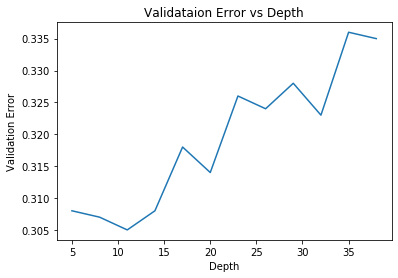

The cross validation error for each depth value is :  [0.308 0.307 0.305 0.308 0.318 0.314 0.326 0.324 0.328 0.323 0.336 0.335]


11

In [18]:
max_depth_bow = tree_max_depth(X_train, y_train)
max_depth_bow

In [19]:
# instantiate learning model max_depth = max_depth_bow
clf = DecisionTreeClassifier(max_depth = max_depth_bow, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)   
# predict the response
pred = clf.predict(x_test)

In [20]:
train_acc_bow = clf.score(X_train, y_train)
print("Train accuracy:", train_acc_bow)

Train accuracy: 0.7555714285714286


In [21]:
test_acc_bow = roc_auc_score(y_test, pred) * 100
print('\nThe test accuracy of decision tree with depth = %f is %.2f%%' % (max_depth_bow, test_acc_bow))


The test accuracy of decision tree with depth = 11.000000 is 71.25%


In [22]:
from sklearn.metrics import f1_score
f1_score(y_test, pred)

0.8126072041166381

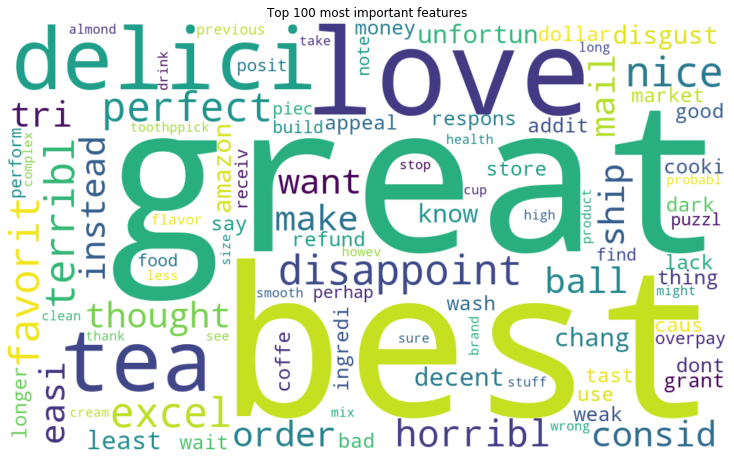

In [23]:
from wordcloud import WordCloud, STOPWORDS

features = bow.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show() 

In [24]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 231,   91],
       [ 783, 1895]], dtype=int64)

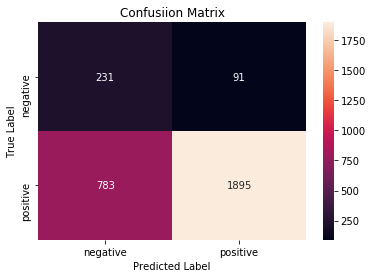

In [25]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [26]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.23      0.72      0.35       322
           1       0.95      0.71      0.81      2678

    accuracy                           0.71      3000
   macro avg       0.59      0.71      0.58      3000
weighted avg       0.88      0.71      0.76      3000



# Tf-Idf

In [27]:
# data
X = final_100k["CleanedText"]

In [28]:
# Target/class-label
y = final_100k["Score"]

In [29]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_trn = X_train
X_train

<7000x182857 sparse matrix of type '<class 'numpy.float64'>'
	with 492517 stored elements in Compressed Sparse Row format>

In [31]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_tst = x_test
x_test.shape

(3000, 182857)


The optimal depth is 14.


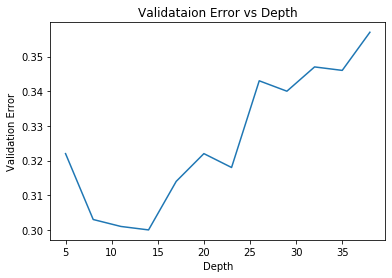

The cross validation error for each depth value is :  [0.322 0.303 0.301 0.3   0.314 0.322 0.318 0.343 0.34  0.347 0.346 0.357]


14

In [32]:
# To choose optimal_depth using cross validation
#from sklearn.model_selection import KFold
max_depth_tfidf = tree_max_depth(X_train, y_train)
max_depth_tfidf

In [33]:
# instantiate learning model max_depth = mas_depth_tfidf
clf = DecisionTreeClassifier(max_depth = max_depth_tfidf, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)

In [34]:
train_acc_tfidf = clf.score(X_train, y_train)
print("Train accuracy %f%%:" % (train_acc_tfidf))

Train accuracy 0.766429%:


In [35]:
test_acc_tfidf = roc_auc_score(y_test, pred) * 100
print('\nThe accuracy of the decision tree with depth = %f is %.2f%%' % (max_depth_tfidf, test_acc_tfidf))


The accuracy of the decision tree with depth = 14.000000 is 71.19%


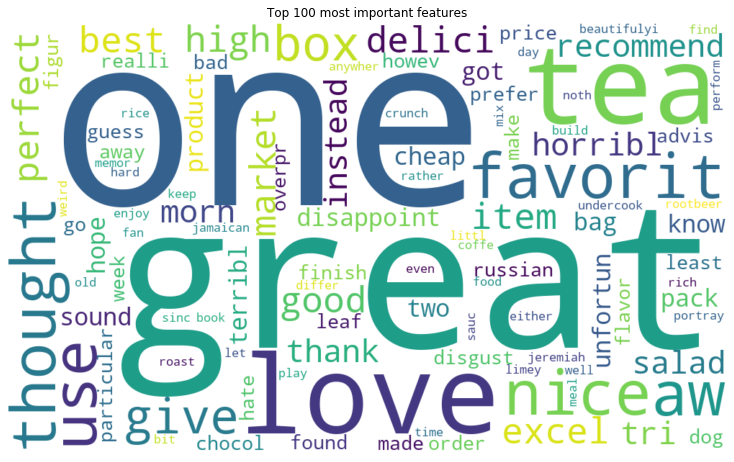

In [36]:
from wordcloud import WordCloud, STOPWORDS

features = tf_idf_vect.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show() 

In [37]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 227,   95],
       [ 753, 1925]], dtype=int64)

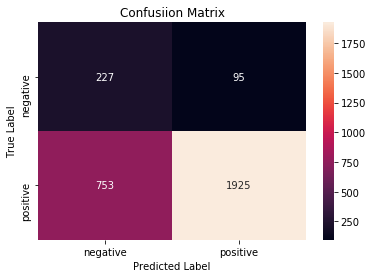

In [38]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [39]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.23      0.70      0.35       322
           1       0.95      0.72      0.82      2678

    accuracy                           0.72      3000
   macro avg       0.59      0.71      0.58      3000
weighted avg       0.88      0.72      0.77      3000



# Word2vec

In [40]:
# data
X = final_100k["Text"]
y = final_100k["Score"]

In [41]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [42]:
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [43]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
#for sent in final_40k['Text'].values:
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [44]:
w2v_model_train = gensim.models.Word2Vec(list_of_sent, min_count = 5, size = 50, workers = 4)

In [45]:
w2v_model_train.wv.most_similar('like')

[('prefer', 0.800281286239624),
 ('think', 0.7784281969070435),
 ('maybe', 0.7145739197731018),
 ('but', 0.69687819480896),
 ('enjoy', 0.6752663254737854),
 ('smell', 0.6720890402793884),
 ('say', 0.647942066192627),
 ('vanillin', 0.64273601770401),
 ('mean', 0.6392996311187744),
 ('overwhelm', 0.6383106708526611)]

In [46]:
w2v_train = w2v_model_train[w2v_model_train.wv.vocab]

In [47]:
w2v_train.shape

(5793, 50)

In [48]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [49]:
w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count = 5, size = 50, workers = 4)

In [50]:
w2v_model_test.wv.most_similar('like')

[('not', 0.9587156772613525),
 ('too', 0.9568084478378296),
 ('really', 0.9480990171432495),
 ('do', 0.9419262409210205),
 ('want', 0.9383376836776733),
 ('thank', 0.9371376633644104),
 ('but', 0.9332333207130432),
 ('dont', 0.9290750026702881),
 ('need', 0.9231641888618469),
 ('tell', 0.9221784472465515)]

In [51]:
w2v_test = w2v_model_test[w2v_model_test.wv.vocab]

In [52]:
w2v_test.shape

(2759, 50)

# Average word2vec

In [53]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

7000
50


In [54]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

3000
50


In [55]:
X_train = sent_vectors
#X_train

In [56]:
x_test = sent_vectors_test
#x_test


The optimal depth is 5.


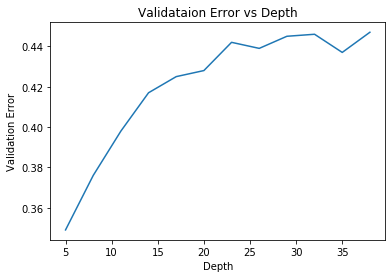

The cross validation error for each depth value is :  [0.349 0.376 0.398 0.417 0.425 0.428 0.442 0.439 0.445 0.446 0.437 0.447]


5

In [57]:
# To choose best depth using cross validation
max_depth_avgw2v = tree_max_depth(X_train, y_train)
max_depth_avgw2v

In [58]:
# instantiate learning model maz_depth = max_depth_avgw2v
clf = DecisionTreeClassifier(max_depth = max_depth_avgw2v, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)

In [59]:
train_acc_avgw2v = clf.score(X_train, y_train)
test_acc_avgw2v = roc_auc_score(y_test, pred) * 100
print("Train accuracy:", train_acc_avgw2v)
print('\nThe accuracy of the decision tree with depth = %f is %.2f%%' % (max_depth_avgw2v, test_acc_avgw2v))

Train accuracy: 0.6824285714285714

The accuracy of the decision tree with depth = 5.000000 is 52.64%


In [60]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  42,  280],
       [ 208, 2470]], dtype=int64)

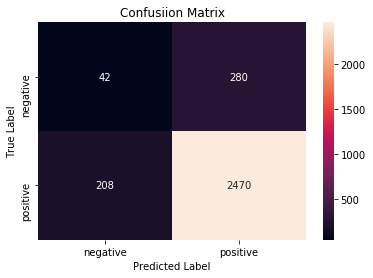

In [61]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [62]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.17      0.13      0.15       322
           1       0.90      0.92      0.91      2678

    accuracy                           0.84      3000
   macro avg       0.53      0.53      0.53      3000
weighted avg       0.82      0.84      0.83      3000



In [67]:
# model performence table
import pandas as pd
models = pd.DataFrame({'Model': ['Decision tree with Bow', "Decision tree with TFIDF", "Decision tree with avgw2v"], 'Hyper Parameter(depth)': [max_depth_bow, max_depth_tfidf, max_depth_avgw2v], 'Train Error': [1-train_acc_bow, 1-train_acc_tfidf, 1-train_acc_avgw2v], 'Test Error': [100-test_acc_bow, 100-test_acc_tfidf, 100-test_acc_avgw2v], 'Auc Score': [test_acc_bow, test_acc_tfidf, test_acc_avgw2v]}, columns = ["Model", "Hyper Parameter(depth)", "Train Error", "Test Error", "Auc Score"])
models.sort_values(by = 'Auc Score', ascending=False)

,Model,Hyper Parameter(depth),Train Error,Test Error,Auc Score
0,Decision tree with Bow,11,0.244429,28.749554,71.250446
1,Decision tree with TFIDF,14,0.233571,28.810552,71.189448
2,Decision tree with avgw2v,5,0.317571,47.361756,52.638244
